In [1]:
import numpy as np
import pandas as pd
import copy

In [2]:
dict_param = np.load('../data/dict_param_all_12.npy', allow_pickle=True).item()

In [3]:
bipartite_normed_product = np.load('../results/centrality_files/bipartite_normed_product_all_12.npy', allow_pickle=True)

In [4]:
vax_distribution = {} 
vax_distribution['original'] = 1 - dict_param['unvax']

In [5]:
ori_sizes = dict_param['cbg_sizes']

In [6]:
vc = 1 - np.average(dict_param['unvax'], weights=dict_param['cbg_sizes'])

In [8]:
state_codes = [cbg//10000000000 for cbg in dict_param['cbgs_to_idxs']]
state_code_set = set(state_codes)

vaccine_rate_cbg_e = dict_param['unvax']
vax_reverse_all = copy.deepcopy(vaccine_rate_cbg_e)

In [9]:
dict_param['vaccination_rate'] = 1 - vaccine_rate_cbg_e
np.random.shuffle(dict_param['vaccination_rate'])
avg = np.average(dict_param['vaccination_rate'], weights=ori_sizes)
vax_distribution['shuffle'] = dict_param['vaccination_rate'] - avg + vc

In [10]:
state_codes = [cbg//10000000000 for cbg in dict_param['cbgs_to_idxs']]
state_code_set = set(state_codes)

vax_reverse_all = copy.deepcopy(vaccine_rate_cbg_e)

for state_code in state_code_set:
    vaxs = np.array([(1 - vaccine_rate_cbg_e[i]) for cbg, i in dict_param['cbgs_to_idxs'].items() if cbg // 10000000000 == state_code])
    vaxs_reverse = np.array([1 - (1 - vaccine_rate_cbg_e[i]) for cbg, i in dict_param['cbgs_to_idxs'].items() if cbg // 10000000000 == state_code])
    cbg_sizes = np.array([dict_param['cbg_sizes'][i] for cbg, i in dict_param['cbgs_to_idxs'].items() if cbg // 10000000000 == state_code])
    vaxs_reverse_adjust = vaxs_reverse - np.average(vaxs_reverse, weights=cbg_sizes) + np.average(vaxs, weights=cbg_sizes)

    vaxs_reverse_adjust = np.maximum(0, vaxs_reverse_adjust)
    vaxs_reverse_adjust = np.minimum(1, vaxs_reverse_adjust)

    ii = 0
    for cbg, i in dict_param['cbgs_to_idxs'].items():
        if cbg // 10000000000 == state_code:
            vax_reverse_all[i] = vaxs_reverse_adjust[ii]
            ii += 1

vax_distribution['reverse_within'] = copy.deepcopy(vax_reverse_all)


In [12]:
centrality_scores_array = np.array(bipartite_normed_product)

centrality_scores = {ii: centrality_scores_array[ii] for ii in range(len(centrality_scores_array))}
centrality_scores = list(reversed(sorted(centrality_scores.items(), key=lambda x: x[1])))

states_centrality_scores = {}

for i, c in centrality_scores:
    state_code = dict_param['all_unique_cbgs'][i] // 10000000000
    if state_code not in states_centrality_scores:
        states_centrality_scores[state_code] = []
    states_centrality_scores[state_code].append((i, c))

vaccine_rate_cbg_inter = 1 - copy.deepcopy(vaccine_rate_cbg_e)

In [13]:
vaccine_rate_cbg_inter = 1 - copy.deepcopy(vaccine_rate_cbg_e)

ii = 0
for ii in range(int(0.01 * len(centrality_scores)), len(centrality_scores), 2):
    cbg = centrality_scores[ii][0]
    if ii + 1 < len(centrality_scores):
        cbg2 = centrality_scores[ii+1][0]
        tmp = vaccine_rate_cbg_inter[cbg]
        vaccine_rate_cbg_inter[cbg] = vaccine_rate_cbg_inter[cbg2]
        vaccine_rate_cbg_inter[cbg2] = tmp


vax_distribution['exchange'] = copy.deepcopy(vaccine_rate_cbg_inter)
vax_distribution['exchange'] -= np.average((vaccine_rate_cbg_inter), weights=ori_sizes) - vc

vax_distribution['exchange'] = np.maximum(0, vax_distribution['exchange'])
vax_distribution['exchange'] = np.minimum(1, vax_distribution['exchange'])

In [14]:
vaccine_rate_cbg_inter = 1 - copy.deepcopy(vaccine_rate_cbg_e)
vax_all = np.flip(np.sort(vaccine_rate_cbg_inter))

ii = 0
for ii in range(0, len(centrality_scores)):
    cbg = centrality_scores[ii][0]
    vaccine_rate_cbg_inter[cbg] = vax_all[ii]

vax_distribution['order'] = copy.deepcopy(vaccine_rate_cbg_inter)
vax_distribution['order'] -= np.average((vaccine_rate_cbg_inter), weights=ori_sizes) - vc

vax_distribution['order'] = np.maximum(0, vax_distribution['order'])
vax_distribution['order'] = np.minimum(1, vax_distribution['order'])

In [15]:
np.save('../results/vax_distribution.npy', vax_distribution)

## So far we generated the input 

In [ ]:
# run the code (this may take long time; see synhetic networks for the demo)
!python US_simulation-track-12-given_distribution.py  --vc=-1 --num_hours=720 --p_sick_at_t0=0.001 --poi_psi=120000000.0  --home_beta=0.005 --state=all --enable=0 --distribution=exchange
!python US_simulation-track-12-given_distribution.py  --vc=-1 --num_hours=720 --p_sick_at_t0=0.001 --poi_psi=120000000.0  --home_beta=0.005 --state=all --enable=0 --distribution=shuffle
!python US_simulation-track-12-given_distribution.py  --vc=-1 --num_hours=720 --p_sick_at_t0=0.001 --poi_psi=120000000.0  --home_beta=0.005 --state=all --enable=0 --distribution=order
!python US_simulation-track-12-given_distribution.py  --vc=-1 --num_hours=720 --p_sick_at_t0=0.001 --poi_psi=120000000.0  --home_beta=0.005 --state=all --enable=0 --distribution=reverse_within

In [32]:
results = {}

for key in ['reverse_within', 'exchange', 'shuffle', 'order']:
    results[key] = np.load('../results/results_all_%s_720_intervene_0_120000000_0.46.npy' % (key), allow_pickle=True).item()

In [37]:
results['original'] = np.load('../results/results_12_ind_all_slow_plus_720_1.npy', allow_pickle=True).item()

In [38]:
total_pop = results['original'][(-1.0, 0.001, 0.005, 120000000.0, 720, False)]['original'].CBG_SIZES.sum()

In [45]:
results['original'] = results['original'][(-1.0, 0.001, 0.005, 120000000.0, 720, False)]['original'].history['all']['new_cases']

for key in ['reverse_within', 'exchange',
            'shuffle', 'order']:
    results[key] = results[key][(-1.0, 0.001, 0.005, 120000000.0, 720, False)][key]['all']['new_cases']

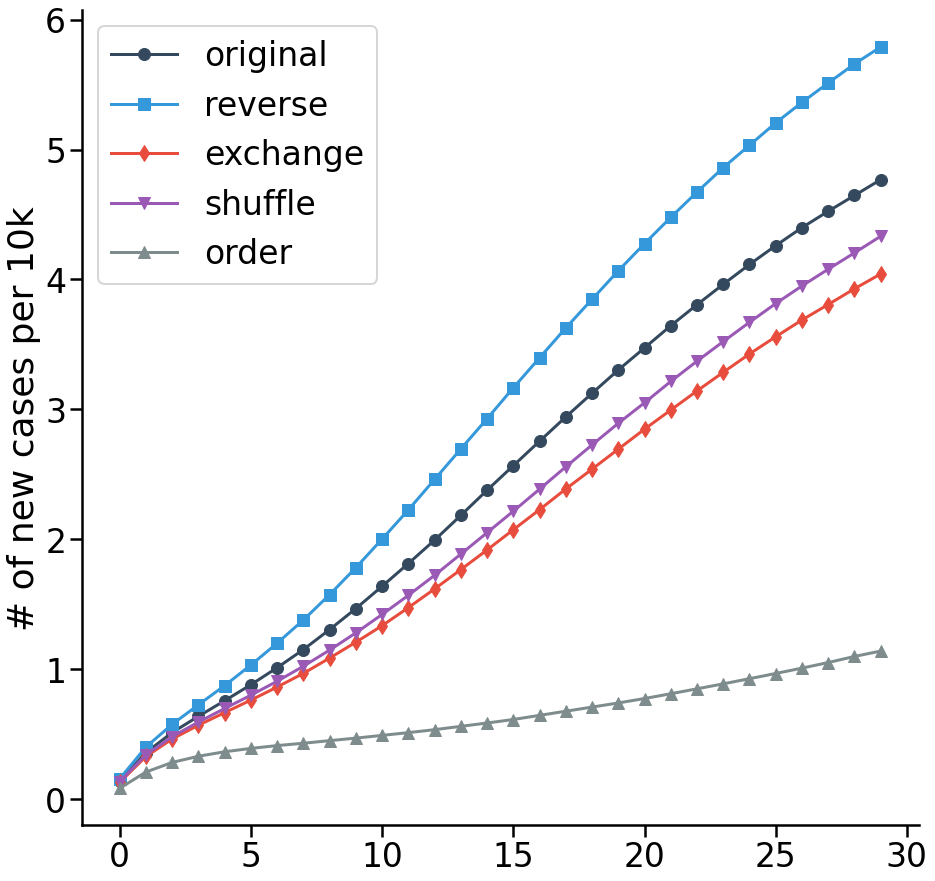

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))

sns.set_context('poster', font_scale=1.5)
sns.set_palette(['#34495e', '#3498db', '#e74c3c', '#9b59b6', '#7f8c8d'])

markers = ['o', 's', 'd', 'v', '^']

mi = 0
for key in ['original', 
            'reverse_within', 
            'exchange', 
            'shuffle', 
            'order',
           ]:
    plt.errorbar(range(30), 
                 [results[key][:, 24*d:24*(d+1)].sum(axis=1).mean() / total_pop * 10000 for d in range(30)], 
                 label=key.split('_')[0],
                 marker=markers[mi])
    mi += 1

plt.legend()
plt.ylabel('# of new cases per 10k')

sns.despine()
plt.savefig('../results/US_simulation.pdf')